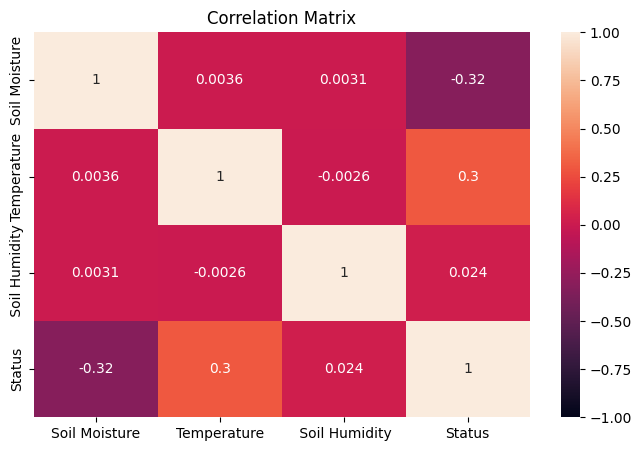

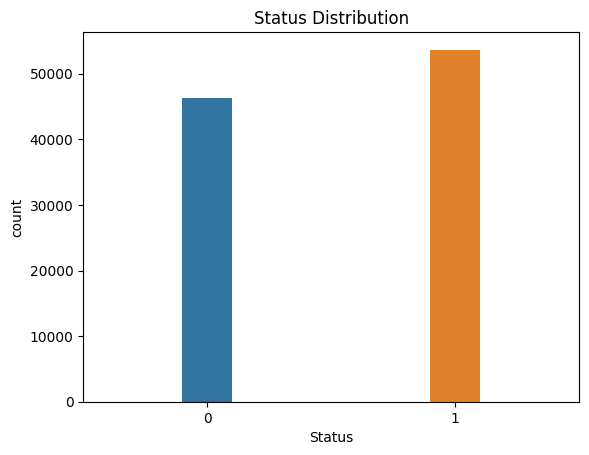

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


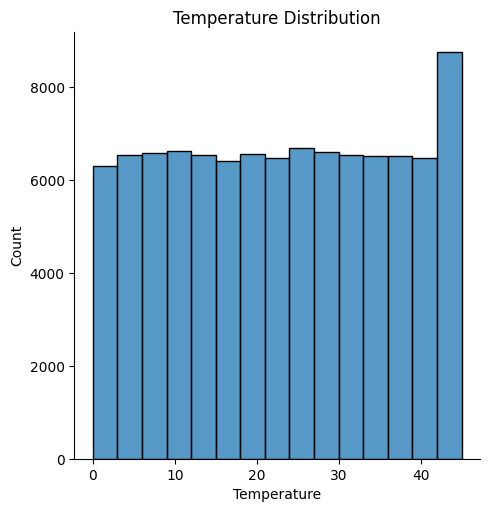

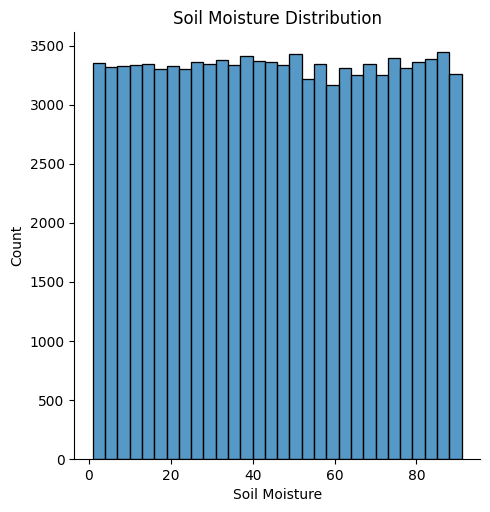

Train dataset saved to: /kaggle/working/processed_data/train.csv
Test dataset saved to: /kaggle/working/processed_data/test.csv
Scaler saved to: /kaggle/working/model/scaler.joblib


In [1]:
#Preprocessing 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from joblib import dump

# Set paths for Kaggle integration
RAW_DATA_DIR = os.environ.get("RAW_DATA_DIR", "/kaggle/input/plante/")  # Replace with your dataset folder
RAW_DATA_FILE = os.environ.get("RAW_DATA_FILE", "TARP.csv")  # Replace with your dataset file name
raw_data_path = os.path.join(RAW_DATA_DIR, RAW_DATA_FILE)

# Set paths for output folders
MODEL_DIR = os.environ.get("MODEL_DIR", "/kaggle/working/model")
PROCESSED_DATA_DIR = os.environ.get("PROCESSED_DATA_DIR", "/kaggle/working/processed_data")

# Create output directories if they don't exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

# Read dataset
df = pd.read_csv(raw_data_path, sep=",")

# Drop irrelevant features
columns_to_drop = [
    'Time', 'Wind gust (Km/h)', 'Wind speed (Km/h)', 
    'Pressure (KPa)', 'ph', 'rainfall', 'N', 'P', 
    'K', 'Air temperature (C)', 'Air humidity (%)'
]
df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Encode 'Status' variable to binary
encoder = LabelBinarizer()
df['Status'] = encoder.fit_transform(df['Status'])

# Data visualization
plt.figure(figsize=(8, 5))
sns.heatmap(data=df.corr(), annot=True, vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

sns.countplot(x="Status", width=0.2, data=df)
plt.title("Status Distribution")
plt.show()

sns.displot(df, x="Temperature", binwidth=3, bins=20, height=5)
plt.title("Temperature Distribution")
sns.displot(df, x="Soil Moisture", binwidth=3, bins=20, height=5)
plt.title("Soil Moisture Distribution")
plt.show()

# Split features and target variable
X = df.drop(columns='Status', axis=1)
y = df['Status']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Combine scaled features and target variable
data = pd.DataFrame(X_scaled, columns=X.columns)
data['Status'] = y.values

# Split train and test datasets
train, test = train_test_split(data, test_size=0.3, stratify=data['Status'], random_state=42)

# Save processed data and scaler
train_path = os.path.join(PROCESSED_DATA_DIR, 'train.csv')
test_path = os.path.join(PROCESSED_DATA_DIR, 'test.csv')
scaler_path = os.path.join(MODEL_DIR, 'scaler.joblib')

train.to_csv(train_path, index=False)
test.to_csv(test_path, index=False)
dump(scaler, scaler_path)

print(f"Train dataset saved to: {train_path}")
print(f"Test dataset saved to: {test_path}")
print(f"Scaler saved to: {scaler_path}")


In [2]:
#Training

import pandas as pd
import json
import os
from joblib import dump
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier

# Set paths to inputs
PROCESSED_DATA_DIR = os.environ.get("PROCESSED_DATA_DIR", "/kaggle/working/processed_data")
train_data_file = 'train.csv'
train_data_path = os.path.join(PROCESSED_DATA_DIR, train_data_file)

# Set paths to outputs
MODEL_DIR = os.environ.get("MODEL_DIR", "/kaggle/working/model")
RESULTS_DIR = os.environ.get("RESULTS_DIR", "/kaggle/working/results")

# Create output directories if they don't exist
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Read data
df = pd.read_csv(train_data_path, sep=",")

# Split data into features and target variables
X_train = df.drop('Status', axis=1)
y_train = df['Status']

# Initialize and train the model
Xgboost_model = XGBClassifier(random_state=21, n_estimators=200, max_depth=5, learning_rate=0.2)
Xgboost_model.fit(X_train, y_train)

# Cross-validation
cv = StratifiedKFold(n_splits=3)
val_model = cross_val_score(Xgboost_model, X_train, y_train, cv=cv).mean()

# Validation accuracy to JSON
train_metadata = {
    'validation_acc': val_model
}

# Paths to save model and metadata
model_name = 'Xgboost_model.joblib'
model_path = os.path.join(MODEL_DIR, model_name)

train_results_file = 'train_metadata.json'
results_path = os.path.join(RESULTS_DIR, train_results_file)

# Serialize and save model
dump(Xgboost_model, model_path)
print(f"Model saved to: {model_path}")

# Serialize and save metadata
with open(results_path, 'w') as outfile:
    json.dump(train_metadata, outfile)
print(f"Training metadata saved to: {results_path}")

# Display validation accuracy
print(f"Cross-Validation Accuracy: {val_model:.4f}")



Model saved to: /kaggle/working/model/Xgboost_model.joblib
Training metadata saved to: /kaggle/working/results/train_metadata.json
Cross-Validation Accuracy: 0.7378


In [3]:
#Testing 
import pandas as pd
from joblib import load
from sklearn.metrics import accuracy_score, classification_report, f1_score
import json
import os

# Set paths for inputs
MODEL_DIR = os.environ.get("MODEL_DIR", "/kaggle/working/model")
PROCESSED_DATA_DIR = os.environ.get("PROCESSED_DATA_DIR", "/kaggle/working/processed_data")

model_file = 'Xgboost_model.joblib'
test_data_file = 'test.csv'

model_path = os.path.join(MODEL_DIR, model_file)
test_data_path = os.path.join(PROCESSED_DATA_DIR, test_data_file)

# Load model
print(f"Loading model from: {model_path}")
Xgboost_model = load(model_path)

# Load test data
print(f"Loading test data from: {test_data_path}")
df = pd.read_csv(test_data_path, sep=",")

# Split data into features and target variable
X_test = df.drop('Status', axis=1)
y_test = df['Status']

# Predict
print("Making predictions on the test set...")
model_predictions = Xgboost_model.predict(X_test)

# Compute test accuracy and F1 score
test_acc = accuracy_score(y_test, model_predictions)
test_f1_score = f1_score(y_test, model_predictions)
test_report = classification_report(y_test, model_predictions, output_dict=True)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

# Prepare test metadata
test_metadata = {
    'test_acc': test_acc,
    'test_f1_score': test_f1_score,
    'classification_report': test_report
}

# Set output path
RESULTS_DIR = os.environ.get("RESULTS_DIR", "/kaggle/working/results")
os.makedirs(RESULTS_DIR, exist_ok=True)

test_results_file = 'test_metadata.json'
results_path = os.path.join(RESULTS_DIR, test_results_file)

# Serialize and save test metadata
print(f"Saving test results to: {results_path}")
with open(results_path, 'w') as outfile:
    json.dump(test_metadata, outfile)

print("Testing completed successfully.")


Loading model from: /kaggle/working/model/Xgboost_model.joblib
Loading test data from: /kaggle/working/processed_data/test.csv
Making predictions on the test set...
Test Accuracy: 0.7413
Test F1 Score: 0.7688
Saving test results to: /kaggle/working/results/test_metadata.json
Testing completed successfully.
